Teste de ciência de dados Magroove
=======================

### Introdução
O objetivo deste teste é acessar sua capacidade de usar a ciência de dados para resolver um problema da vida real. Como a natureza do problema é tão complexa, não esperamos que sua solução seja definitiva ou de alto desempenho - na verdade, não nos importamos com a precisão de seus resultados. O que realmente nos importa é o seu processo de pensamento ou a maneira como você lida com um problema, destila-o em algo solucionável por uma máquina e transforma tudo isso em código. Como você pode imaginar neste momento, este teste girará em torno de um problema de aprendizado de máquina - um de classificação para ser mais específico, então vamos ao que interessa.

### O problema
Ao enviar um álbum para plataformas de streaming digital (DPSs) como Spotify, Apple ou assim por diante, é importante que todos os metadados que acompanham esse álbum sejam precisos. Os metadados incluem informações básicas como o nome do álbum, o ano em que foi gravado, os artistas envolvidos nas faixas e muito mais. Neste exercício estamos particularmente interessados ​​em um elemento específico dos metadados - idioma.

O idioma é uma parte importante dos metadados, pois ajuda os DPSs a recomendar um determinado álbum para ouvintes que entendem esse idioma e provavelmente o apreciarão. Por causa disso, os DSPs são bastante rigorosos com o idioma correto sendo atribuído ao receber um álbum.

No entanto, ocorre com bastante frequência que nossos usuários preencham incorretamente o campo de idioma em nosso formulário ao enviar um álbum, o que posteriormente leva a conflitos entre o usuário em questão, nossa empresa e os DSPs. O objetivo deste teste então é trabalhar em uma solução para uma versão simplificada desse problema.

Junto com esta descrição, você encontrará dois arquivos - dataset-hindi.csv e dataset-spanish.csv. Os nomes são bastante intuitivos, cada um contém metadados de álbuns que já distribuímos e que sabemos que seus metadados estão escritos em espanhol ou hindi. Cada CSV contém três colunas - artist_name, release_name e song_name. Embora os nomes sejam bastante intuitivos, deve-se atentar para o fato de que as colunas nome_do_artista e nome_do_lançamento tendem a ter entradas repetidas, pois o mesmo artista pode ter vários álbuns e um álbum pode ter várias músicas.

**Seu objetivo é criar um modelo para classificar metadados futuros como escritos em espanhol ou hindi.**

### As entregas
Esperamos receber de você um único script python (run.py) e um arquivo de requisitos (requirements.txt) listando todas as dependências para executá-lo. Seu script deve ser escrito usando Python 3.xe deve gerar um modelo que possamos usar posteriormente para inferência em um ambiente semelhante à produção. Você pode usar qualquer pacote ou biblioteca que desejar, desde que não use nenhum modelo pré-treinado. Você também está proibido de usar APIs ou serviços de terceiros para inferência de idioma, como AWS Comprehend ou GCP Translation. Seu script único deve conter tudo, desde limpeza e pré-processamento de dados até treinamento e inferência de modelos.

### Avaliação e considerações finais

Novamente, mesmo que a precisão seja sempre uma boa métrica, nosso foco principal definitivamente não será o desempenho (estaríamos realizando uma competição Kaggle se fosse =) ). Nossa atenção estará na lógica que você usou para tentar resolver o problema e como ele foi traduzido em código. Portanto, não se preocupe se o seu modelo tiver um desempenho ruim no final - escolheríamos nove em cada dez vezes um desempenho ruim do modelo com uma abordagem inteligente e tentaremos resolver o problema em questão.

E, finalmente, não hesite em entrar em contato se tiver alguma dúvida, dúvida ou simplesmente precisar de um pontapé inicial. Aqui na Magroove temos uma forte cultura de ajudar uns aos outros - então você pode definitivamente contar conosco - e prometemos que qualquer pedido de ajuda não afetará sua avaliação. No final, resolver problemas desafiadores é principalmente fazer as perguntas certas, então perguntas bem pensadas são mais do que bem-vindas. Então boa sorte com seu teste e nos mantenha informados!

##  Visualização dos Dados

In [1]:
import pandas as pd
import numpy as np
import unidecode
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer # (converter as colunas em um array)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Importando os dados
df_sp = pd.read_csv('dataset-spanish.csv', header = 0)
df_hi = pd.read_csv('dataset-hindi.csv', header = 0)

In [3]:
# Visualização dos dados
df_sp.sample(5)

,artist_name,release_name,song_name
2624,Esteban Estevez,Senderos,Nena Nena
3813,LGL10,Mi Primera Vez,"Feb 28, 04.58 Pm"
1275,Asumandão,Andar Y Andar,Andar Y Andar
4376,Groovit,The Arrival,Su Brillante Razon
1151,Rocky Walrus,Green Light,Love


In [4]:
# Visualização dos dados
df_hi.sample(5)

,artist_name,release_name,song_name
2774,WeWakeMusic,Bekhabar,Bekhabar
830,Sawriz,Gangsta Shit,Gangsta Shit
4756,Shiny Happy People,Aao Blog Lagao Radhe Mohan,(Online Audio converter.com)
1633,Devansu Rathva,Hasi Wadiya Mix,Hasi Wadiya Mix
4711,BHOLE KA PRASAD By Jassi mahant 36,Bhole Ka Prasad by Jassi Mahant 36,Bhole Ka Prasad


In [5]:
# Checking the dataset lenght
print(f'Spanish dataset length: {len(df_sp)} \nHindi dataset lenght: {len(df_hi)}')

Spanish dataset length: 5000 
Hindi dataset lenght: 5000


In [6]:
# Describe dos dados
df_sp.describe()


,artist_name,release_name,song_name
count,5000,4999,4999
unique,1415,1870,4702
top,Various,Cumbias Sonideras,Title Error
freq,134,134,24


In [7]:
df_hi.describe()

,artist_name,release_name,song_name
count,5000,5000,4997
unique,2436,4034,4616
top,Visual Chinmay,Vibeee:),Title Error
freq,134,59,33


## Data Cleaning

> Before starting the data cleaning process, I'll add the column Idiom in the datasets so I can already concatenate them to make the cleaning only for one dataset

In [8]:
# Adding a 'Idiom' column
df_sp['Idiom'] = 'Spanish'
df_hi['Idiom'] = 'Hindi'

In [9]:
# Concatenating the datasets
df = pd.concat([df_sp, df_hi])
len(df)

10000

In [10]:
# Dropping duplicated rows
df.drop_duplicates(inplace= True)

In [11]:
# Checkin missing values
df.isna().sum()

artist_name     0
release_name    1
song_name       4
Idiom           0
dtype: int64

In [12]:
# Dropping the rows with missing values
df.dropna(inplace=True)

In [13]:
# Checking dataset lenght after dropping the duplications for the spanish and the hindi (so we can see if it's still balanced)
print(f"Spanish dataset length: {len(df[(df.Idiom == 'Spanish')])} \nHindi dataset lenght: {len(df[(df.Idiom == 'Hindi')])}")

Spanish dataset length: 4935 
Hindi dataset lenght: 4906


In [14]:
df.describe()

,artist_name,release_name,song_name,Idiom
count,9841,9841,9841,9841
unique,3843,5891,9299,2
top,Various,Cumbias Sonideras,Title Error,Spanish
freq,134,134,31,4935


In [15]:
# Taking a deep look into the variables to clean it properly
df['song_name'].value_counts()

Title Error              31
Intro                     9
TITLE_ERROR               7
Contigo                   6
Ranjha                    5
                         ..
Me Llevo a Las Gyales     1
Yuca                      1
Cash Out                  1
Lunes Rahib               1
The Devue                 1
Name: song_name, Length: 9299, dtype: int64

In [16]:
# I'll remove the rows with Title Error (and TITLE_ERROR) and also the Intro songs, since it doesn't mean much about the idiom of the song (which is what we are looking for in this project)
df = df[(df.song_name != 'Title Error') & (df.song_name != 'TITLE_ERROR') & (df.song_name.str.startswith('Intro') == False)]

In [17]:
df.describe()

,artist_name,release_name,song_name,Idiom
count,9781,9781,9781,9781
unique,3822,5864,9283,2
top,Various,Cumbias Sonideras,Contigo,Spanish
freq,134,134,6,4903


In [18]:
# Removing possible double whitespace in the text
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = re.sub(r'\s+', ' ', df[(df.columns.values[i])].values[j])

In [19]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
1025,La Caja Negra Produce,Recopilacion,En Mi Nave,Spanish
937,Young Vega,Pa Que Tiras?,Pa Que Tiras?,Spanish
653,Visual Chinmay,Brown Munde X Bajre Da Sitta X Competition X B...,Brown Munde X Bajre Da Sitta X Boro Boro Mashup,Hindi
4380,Dj Victor Hugo Carrillo Melendez,Somos Del Barrio,Somos Del Barrio,Spanish
4516,Rosario Vallejos Angulo (Rossy Vallejos),Tú Me Diste Valor,Digno De Loor,Spanish


> O que fazer com os registro que possuem grande quantidade de valores repetidos como em 'release_name' e 'artist_name' ???

## Pré-Processing

> Fisrt of all, in my understanding the artist_name usually is not related to the Idiom, since names are names, and we also have a lot of 'fake' name for artists, that many times don't make sense, or is even in another language

In [20]:
# # Dropping the artist_name column
# df.drop('artist_name', axis = 1, inplace = True)

### Removing accented characters

In [21]:
# Removing accented characters
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = unidecode.unidecode(df[(df.columns.values[i])].values[j])

In [22]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
1836,The S.L King,"Cypher(Jymc,Lilbe,RgKlan)",Cypher,Spanish
847,Soyab Khan Barota,Soyab Khan Barota,Soyab Khan Barota,Hindi
4762,Various,Cumbias Sonideras,Gritaria,Spanish
3359,Rubiel soto el cantante del amor,Rubiel Soto El Cantante Del Amor,Un Novio Como Yo,Spanish
2757,Veinticuatrosiete,JAMAS VENCIDOS (todo el pinche guato),Avanzar,Spanish


### Converting the dataset to lowercase

In [23]:
# Converting the dataset to lowercase
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = (df[(df.columns.values[i])].values[j]).lower()

In [24]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
4734,lavish rajora,yaado ka karwa,yaado ka karwa,hindi
4710,jassi mahant 36,cg ka ladka,cg ka ladka,hindi
2928,dream yb,new me,pa' la vuelta,spanish
4534,z-jabetey,rko-music.,ft. juanfer 323 - en la cherokee remix (lyric ...,spanish
1510,calvario death metal,dimension de muerte,dimension de muerte f01,spanish


### Reducing repeated characters and punctuations

In [25]:
# Reducing repeated characters and punctuations
def reducing_incorrect_character_repeatation(text):
    """
    This Function will reduce repeatition to two characters 
    for alphabets and to one character for punctuations.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Finally formatted text with alphabets repeating to 
        two characters & punctuations limited to one repeatition 
        
    Example:
    Input : Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)
    Output : Reallyy, Greeaatt !?.;:)
    
    """
    # Pattern matching for all case alphabets
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    return Final_Formatted

In [26]:
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = reducing_incorrect_character_repeatation(df[(df.columns.values[i])].values[j])

In [27]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
3690,diego,chill kid,atardecer desde el mirador,spanish
1468,mantike,ep2,jungla,spanish
1970,victor anom,i'm fine,i'm fine,hindi
135,mario ojeda,a contramano,"ayer, sin ir mas lejos",spanish
4724,various,cumbias sonideras,no te pongas brava,spanish


> *I still need to do more cleaning regarding this part. We have a lot of songs starting with " . " or blank space*

### Removing Special Characters

In [28]:
# # Removing Special Characters
# for i in range(0,len(df.columns)):
#     for j in range(0, len(df)):
#         df[(df.columns.values[i])].values[j] = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', df[(df.columns.values[i])].values[j])

In [29]:
# Removing Special Characters and also numbers(since the numbers doesn't give any hint regarding idiom)
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = re.sub("[.,;/0-9!?¿%@|~'#+:()-]", '', df[(df.columns.values[i])].values[j])

In [30]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
4509,rosario vallejos angulo rossy vallejos,tu me diste valor,te quiero adorar pista,spanish
1049,torcacita de canaria,dulce naranjita,rosa rosa,spanish
3193,eastern ind,lemas bestie mintapompa,lemas bestie mintapompa,spanish
292,mika singh,tum par hum hai atke,tum par hum hai atke,hindi
750,themadwriter,meri kahani,meri kahani,hindi


In [31]:
# Visualizing data 
df.sort_values('song_name')

,artist_name,release_name,song_name,Idiom
3205,walther pro,resonancia,,spanish
1316,cxcile,,,spanish
671,zevna javi cheuke,jardin botanico,,spanish
4036,zanmala,,,spanish
1908,tchad,ivory waali irony,,hindi
...,...,...,...,...
1792,d i c,zona sur rkt,zona sur rkt,spanish
585,soledad bravo live dec,lost and found latin music tapes,zorongo,spanish
2510,zeta,zta music sessions vol,zta music sessions vol,spanish
1791,bsk brothers,absolute desi vol,zul zul vahe,hindi


In [32]:
# Remove the rows where we got empty values after the pre-processing and couldn't be removed by .dropna()
df[(df.song_name == '')]

,artist_name,release_name,song_name,Idiom
671,zevna javi cheuke,jardin botanico,,spanish
1316,cxcile,,,spanish
1998,oniricboii,,,spanish
2348,seven,,,spanish
2903,j boi,,,spanish
2921,jadix,tena,,spanish
3205,walther pro,resonancia,,spanish
4028,ruido julio,,,spanish
4036,zanmala,,,spanish
1908,tchad,ivory waali irony,,hindi


In [33]:
df = df[(df.song_name != '') & (df.release_name != '') & (df.artist_name != '')]

In [34]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
3256,royal dvirus,pyar ka pareenda,pyar ka pareenda,hindi
1585,apni nagpuri adda,ringtone darling,ringtone darling,hindi
2443,rajat khare,zindagi hai adhoori si,zindagi hai adhoori si,hindi
1377,claver rax,respect,respect,spanish
3903,shri draupadi giri g maharaj,aarti,tulsi mata aarti,hindi


> We could see that some albuns had the 'vol' in its end (indicating which volum it is). Since it's a generic word, it won't help to keep them in our dataset. Let's remove the word then.
 Now that we took the numbers out, lets see how many we have left

In [35]:
df['release_name'].str.endswith('vol ').sum()

49

In [36]:
df['release_name'].str.endswith('vol').sum()

49

In [37]:
# This waay do not work because I'm replacing 'vol' not only in the end of the text
for i in range(0, len(df)):
    if df.release_name.str.endswith('vol ').values[i]:
        df.release_name.values[i] = df.release_name.values[i].replace('vol ', '')
    elif df.release_name.str.endswith('vol').values[i]:
        df.release_name.values[i] = df.release_name.values[i].replace('vol', '')

In [38]:
df['release_name'].str.endswith('vol ').sum()

0

In [39]:
df['release_name'].str.endswith('vol').sum()

0

In [40]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
3763,ganesh kumar hempur,mor sapna me,mor sapna me,hindi
142,aditya music factors,aditya fun zone,gllvniuiu,hindi
135,mario ojeda,a contramano,ayer sin ir mas lejos,spanish
4898,muhammed sharif raza,khawajaekhawajga,khawjaekhawjga,hindi
1162,rocky walrus,green light,a sonar,spanish


In [41]:
# Transformando a variável target 'Idiom' and 0 e 1 ("0" -> 'hindi ; "1" -> spanish)
df['Idiom'] = np.where((df['Idiom']) == 'spanish', 1,0)

In [42]:
df['Idiom'].value_counts()

0    4875
1    4873
Name: Idiom, dtype: int64

In [43]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
999,arijit singh kk ar rahman shankar mahadevan...,loveria mashup in coordination,loveria mashup in coordination,0
3789,udit narayan,udit narayan songs,oodhni,0
2953,hijos del rigor,hechos de la nada,colorado heroe suburbano,1
1116,md nabeel,khud se khafa hu mai,khud se khafa hu mai,0
1546,visual chinmay,kabhi tumhe lofi mashup,kabhi tumhe lofi mashup amtee k,0


## Machine Learning

### Dados de treino e de teste

In [44]:
# x = (df['artist_name'])
x = (df.drop(['Idiom'], axis = 1)) # predictors
y = (df['Idiom']) # target

In [45]:
cv = CountVectorizer()
ct = make_column_transformer((cv,'artist_name'),(cv,'song_name'),(cv,'release_name'))
X = ct.fit_transform(x)

In [46]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

c:\Users\rafajovelho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


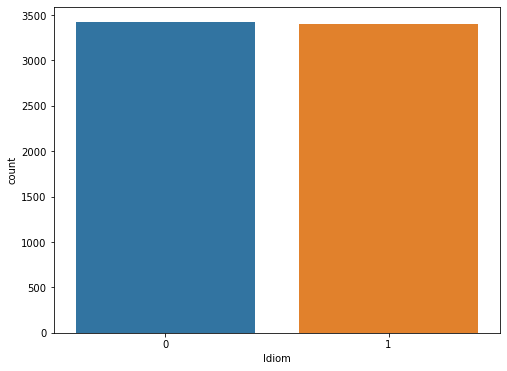

In [47]:
# Verifying if the variable is balanced
plt.figure(figsize = (8,6))

ax = sns.countplot(y_train)

### Algorithm

In [48]:
model = MultinomialNB()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9603418803418804

Talvez criar um algoritmo que não leve o nome do artista em consideração, visto que pode ser qualquer coisa, como siglas, ou um nome em ingles mesmo, msm sendo de outra nacionalidade
